In [5]:
from transformers import pipeline

# Load FinBERT from HuggingFace
finbert = pipeline("text-classification", model="ProsusAI/finbert", top_k=None)

# Sample financial headlines
headlines = [
    "JPMorgan reports record profits in Q3 earnings",
    "Federal Reserve raises interest rates amid inflation fears",
    "Goldman Sachs cuts 3000 jobs in major restructuring",
    "Apple stock surges after strong iPhone sales report",
    "Banking sector faces uncertainty due to credit risk concerns"
]

# Run sentiment prediction
for headline in headlines:
    scores = finbert(headline)[0]
    top = max(scores, key=lambda x: x['score'])
    print(f"Headline : {headline}")
    print(f"Sentiment: {top['label'].upper()} ({top['score']*100:.1f}%)")
    print()

C:\Users\PRASAD\anaconda3\envs\llm_explain\Lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Headline : JPMorgan reports record profits in Q3 earnings
Sentiment: POSITIVE (92.5%)

Headline : Federal Reserve raises interest rates amid inflation fears
Sentiment: NEGATIVE (63.8%)

Headline : Goldman Sachs cuts 3000 jobs in major restructuring
Sentiment: NEGATIVE (96.8%)

Headline : Apple stock surges after strong iPhone sales report
Sentiment: POSITIVE (83.6%)

Headline : Banking sector faces uncertainty due to credit risk concerns
Sentiment: NEGATIVE (94.1%)



In [1]:
import shap
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model.eval()

# Define prediction function for SHAP
def predict(texts):
    # Handle all input types SHAP might pass
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    if isinstance(texts, str):
        texts = [texts]
    texts = [str(t) if not isinstance(t, str) else t for t in texts]
    
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1).detach().numpy()
    return probs

# Pick one headline
headline = "JPMorgan reports record profits in Q3 earnings"

# Use TransformersPipeline explainer - more compatible with transformers
masker = shap.maskers.Text(r"\W+")
explainer = shap.Explainer(predict, masker)
shap_values = explainer([headline])

# Print results
labels = model.config.id2label
print("Label mapping:", labels)
print()
tokens = headline.split()
for idx, label in labels.items():
    print(f"--- {label.upper()} ---")
    for token, value in zip(shap_values[0].data, shap_values[0].values[:, idx]):
        print(f"  {token:20s} : {value:+.4f}")
    print()

C:\Users\PRASAD\anaconda3\envs\llm_explain\Lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
PartitionExplainer explainer: 2it [00:11, 11.93s/it]                                                                   

Label mapping: {0: 'positive', 1: 'negative', 2: 'neutral'}

--- POSITIVE ---
  JPMorgan             : -0.0315
  reports              : +0.0221
  record               : +0.3678
  profits              : +0.4582
  in                   : +0.0040
  Q3                   : +0.0043
  earnings             : +0.0011

--- NEGATIVE ---
  JPMorgan             : -0.0202
  reports              : +0.0238
  record               : -0.0081
  profits              : +0.0076
  in                   : -0.0032
  Q3                   : +0.0027
  earnings             : -0.0056

--- NEUTRAL ---
  JPMorgan             : +0.0517
  reports              : -0.0459
  record               : -0.3598
  profits              : -0.4658
  in                   : -0.0008
  Q3                   : -0.0070
  earnings             : +0.0045



In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model.eval()

C:\Users\PRASAD\anaconda3\envs\llm_explain\Lib\site-packages\huggingface_hub\file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [4]:
from lime.lime_text import LimeTextExplainer
import numpy as np

# Define prediction function for LIME
def predict_proba(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1).detach().numpy()
    return probs

# Label names
class_names = ['positive', 'negative', 'neutral']

# Create LIME explainer
explainer = LimeTextExplainer(class_names=class_names)

# Headline to explain
headline = "JPMorgan reports record profits in Q3 earnings"

# Generate explanation
exp = explainer.explain_instance(headline, predict_proba, num_features=7, num_samples=500, labels=[0, 1, 2])

# Print results
print(f"Headline: {headline}")
print(f"Predicted class: {class_names[exp.predict_proba.argmax()]}")
print()
for label_idx, label_name in enumerate(class_names):
    print(f"--- {label_name.upper()} ---")
    for word, score in exp.as_list(label=label_idx):
        print(f"  {word:20s} : {score:+.4f}")
    print()

Headline: JPMorgan reports record profits in Q3 earnings
Predicted class: positive

--- POSITIVE ---
  record               : +0.4640
  profits              : +0.3781
  reports              : +0.1938
  in                   : +0.1115
  earnings             : +0.0760
  Q3                   : +0.0380
  JPMorgan             : +0.0015

--- NEGATIVE ---
  profits              : -0.0958
  in                   : +0.0718
  JPMorgan             : +0.0565
  Q3                   : +0.0499
  record               : +0.0350
  reports              : -0.0158
  earnings             : +0.0109

--- NEUTRAL ---
  record               : -0.4990
  profits              : -0.2823
  in                   : -0.1833
  reports              : -0.1780
  Q3                   : -0.0879
  earnings             : -0.0869
  JPMorgan             : -0.0580



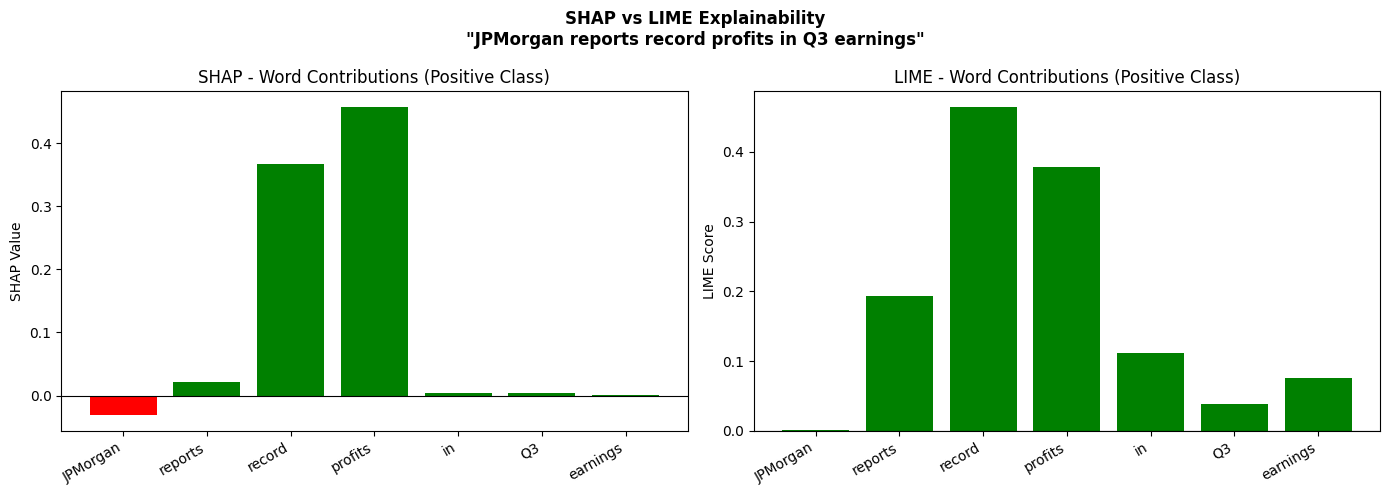

Chart saved as shap_vs_lime.png


In [6]:
import matplotlib.pyplot as plt
import numpy as np

headline = "JPMorgan reports record profits in Q3 earnings"

# SHAP values for POSITIVE class (from Part 2 output)
shap_words =   ["JPMorgan", "reports", "record", "profits", "in", "Q3", "earnings"]
shap_scores =  [-0.0315,     0.0221,    0.3678,   0.4582,   0.0040, 0.0043, 0.0011]

# LIME values for POSITIVE class (from Part 3 output)
lime_words =   ["JPMorgan", "reports", "record", "profits", "in", "Q3", "earnings"]
lime_scores =  [0.0015,      0.1938,    0.4640,   0.3781,   0.1115, 0.0380, 0.0760]

x = np.arange(len(shap_words))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f'SHAP vs LIME Explainability\n"{headline}"', fontsize=12, fontweight='bold')

# SHAP plot
colors_shap = ['green' if s > 0 else 'red' for s in shap_scores]
axes[0].bar(x, shap_scores, color=colors_shap)
axes[0].set_title('SHAP - Word Contributions (Positive Class)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(shap_words, rotation=30, ha='right')
axes[0].set_ylabel('SHAP Value')
axes[0].axhline(0, color='black', linewidth=0.8)

# LIME plot
colors_lime = ['green' if s > 0 else 'red' for s in lime_scores]
axes[1].bar(x, lime_scores, color=colors_lime)
axes[1].set_title('LIME - Word Contributions (Positive Class)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(lime_words, rotation=30, ha='right')
axes[1].set_ylabel('LIME Score')
axes[1].axhline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.savefig('shap_vs_lime.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart saved as shap_vs_lime.png")